## Импорт библиотек

In [1]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import datasets
from torchvision.utils import save_image
from torchvision.utils import make_grid
from torchvision.transforms import transforms
import numpy as np
import matplotlib.pyplot as plt

## Загрузка данных

In [2]:
# !unzip -qq cats.zip 

In [3]:
DATA_DIR = './cats'

In [4]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [5]:
train_data = ImageFolder(
    DATA_DIR, 
    transform=transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize(*stats)
    ])
)

In [6]:
train_loader = DataLoader(train_data, batch_size, shuffle=True, num_workers=20, pin_memory=True)

**Визуализация**

In [7]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [8]:
def show_images(images, nmax=32):
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=32):
    for images, _ in dl:
        show_images(images, nmax)
        break

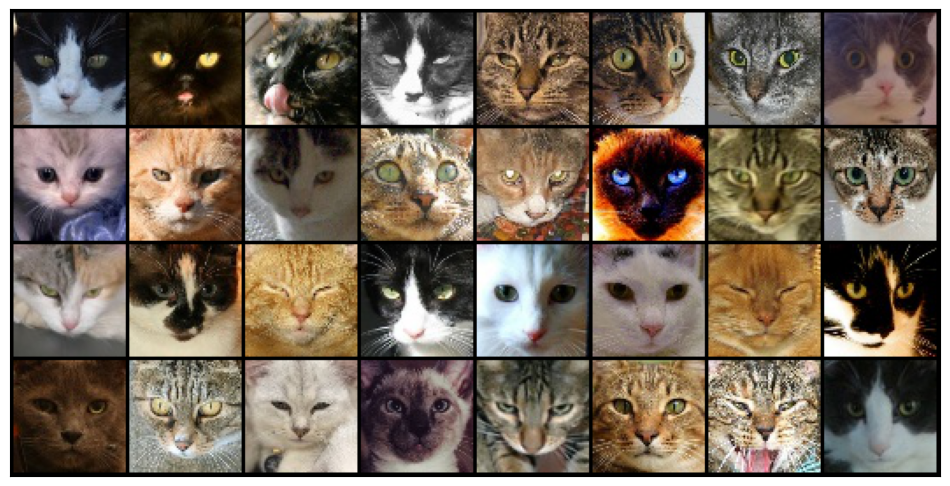

In [9]:
show_batch(train_loader)

## GAN

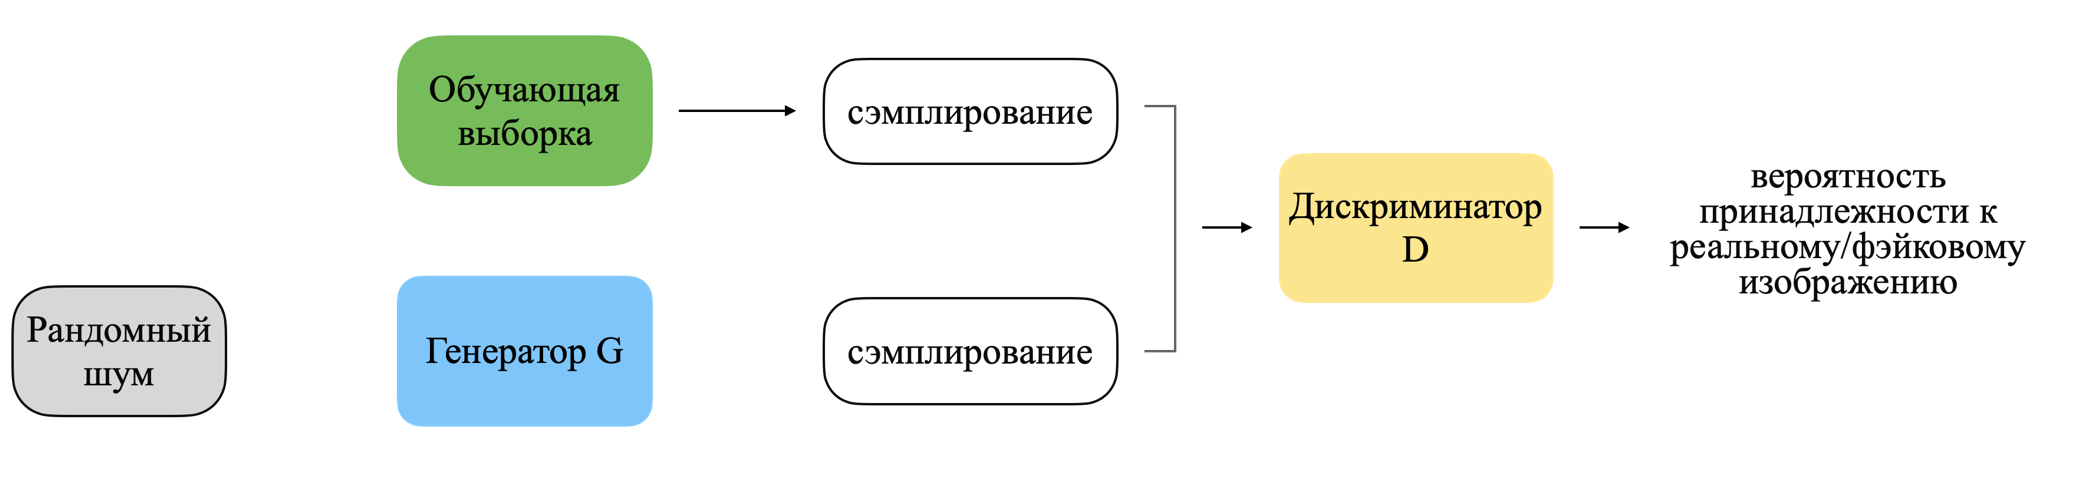

### Генератор

In [10]:
class Generator(nn.Module):

    def __init__(self, z_dim=100, kernel_size=4, stride=2, bias=False, padding=1):
        super().__init__()
        self.image_shape = (3, 64, 64)
        self.model = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 512, kernel_size=kernel_size, stride=1, bias=bias),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=kernel_size, stride=stride, bias=bias, padding=padding),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=kernel_size, stride=stride, bias=bias, padding=padding),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=kernel_size, stride=stride, bias=bias, padding=padding),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, self.image_shape[0], kernel_size=kernel_size, stride=stride, bias=bias, padding=padding)
        )

    def forward(self, z):
        img = self.model(z)
        return img

### Дискриминатор

In [11]:
class Discriminator(nn.Module):

    def __init__(self, kernel_size=4, stride=2, padding=1, bias=False, slope=0.2):
        super().__init__()
        self.image_shape = (3, 64, 64)
        self.model = nn.Sequential(
            nn.Conv2d(self.image_shape[0], 64, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
            nn.LeakyReLU(negative_slope=slope, inplace=True),
            nn.Conv2d(64, 128, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=slope, inplace=True),
            nn.Conv2d(128, 256, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=slope, inplace=True),
            nn.Conv2d(256, 512, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(negative_slope=slope, inplace=True),
            nn.Conv2d(512, 1, kernel_size=kernel_size, stride=1, bias=bias),
            nn.Sigmoid()
        )

    def forward(self, img):
        output = self.model(img)
        return output

## Обучение

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [13]:
epochs = 30
lr = 0.0002
batch_size = 64
loss = nn.BCELoss()

In [14]:
fixed_noise = torch.randn(64, 100, 1, 1, device=device)

In [15]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [16]:
G = Generator().to(device)
D = Discriminator().to(device)
weights_init(G)
weights_init(D)
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

In [17]:
def generate_images(fakes, image_folder, epoch):
    # Фунцкция для создания сетки и сохранения изображений
    image_grid = make_grid(fakes.to(device),padding=2,nrow=4,normalize=True)
    if not os.path.exists(image_folder):
        os.makedirs(image_folder)
    save_image(image_grid,'{}/img_{}.png'.format(image_folder,epoch))

In [18]:
losses_g = []
losses_d = []


for epoch in range(epochs):
    for idx, (imgs, _) in enumerate(train_loader):
        idx += 1

        # Обучаем дискриминатор
        # Real inputs - реальные картинки из MNIST
        # Fake inputs - выход генератора
        # Real inputs должны быть классифицированы как 1, fake - 0
        real_inputs = imgs.to(device)
        real_outputs = D(real_inputs)
        real_label = torch.ones_like(real_outputs).to(device)

        noise = torch.randn(batch_size, 100, 1, 1, device=device)
        fake_inputs = G(noise)
        fake_outputs = D(fake_inputs)
        fake_label = torch.zeros_like(fake_outputs).to(device)

        outputs = torch.cat((real_outputs, fake_outputs))
        targets = torch.cat((real_label, fake_label))
        D_loss = loss(outputs, targets)
        
        D_optimizer.zero_grad()
        D_loss.backward()
        D_optimizer.step()

        # Обучаем генератор
        # Цель генератора - заставить дискриминатор верить, что все картинки класса 1
        noise = torch.randn(batch_size, 100, 1, 1, device=device)

        fake_inputs = G(noise)
        fake_outputs = D(fake_inputs)
        # Пытаемся обмануть дискриминатор
        fake_targets = torch.ones_like(fake_outputs).to(device)
        G_loss = loss(fake_outputs, fake_targets)
        G_optimizer.zero_grad()
        G_loss.backward()
        G_optimizer.step()

        # Сохраняем лосс обоих подмоделей
        losses_g.append(G_loss)
        losses_d.append(D_loss)


        if idx % 100 == 0 or idx == len(train_loader):
            print('Epoch {} Iteration {}: discriminator_loss {:.3f} generator_loss {:.3f}'.format(epoch, idx, D_loss.item(), G_loss.item()))

        # Сохраняем сгенерированные изображения
        with torch.no_grad():
          fakes = G(fixed_noise)
          image_folder = './generated_images'
          generate_images(fakes, image_folder, epoch)

    if (epoch+1) % 10 == 0:
        torch.save(G, 'Generator_epoch_{}.pth'.format(epoch))
        print('Model saved.')

Epoch 0 Iteration 100: discriminator_loss 0.223 generator_loss 1.825
Epoch 0 Iteration 124: discriminator_loss 0.225 generator_loss 5.834
Epoch 1 Iteration 100: discriminator_loss 0.439 generator_loss 1.230
Epoch 1 Iteration 124: discriminator_loss 0.656 generator_loss 7.895
Epoch 2 Iteration 100: discriminator_loss 0.575 generator_loss 3.675
Epoch 2 Iteration 124: discriminator_loss 0.613 generator_loss 8.820
Epoch 3 Iteration 100: discriminator_loss 0.228 generator_loss 2.460
Epoch 3 Iteration 124: discriminator_loss 0.698 generator_loss 10.070
Epoch 4 Iteration 100: discriminator_loss 0.702 generator_loss 5.337
Epoch 4 Iteration 124: discriminator_loss 0.164 generator_loss 7.394
Epoch 5 Iteration 100: discriminator_loss 0.353 generator_loss 4.740
Epoch 5 Iteration 124: discriminator_loss 0.317 generator_loss 8.373
Epoch 6 Iteration 100: discriminator_loss 0.268 generator_loss 2.670
Epoch 6 Iteration 124: discriminator_loss 0.196 generator_loss 8.564
Epoch 7 Iteration 100: discrimina

In [19]:
from IPython.display import Image

In [20]:
!ls ./generated_images

img_0.png   img_13.png	img_18.png  img_22.png	img_27.png  img_5.png
img_1.png   img_14.png	img_19.png  img_23.png	img_28.png  img_6.png
img_10.png  img_15.png	img_2.png   img_24.png	img_29.png  img_7.png
img_11.png  img_16.png	img_20.png  img_25.png	img_3.png   img_8.png
img_12.png  img_17.png	img_21.png  img_26.png	img_4.png   img_9.png


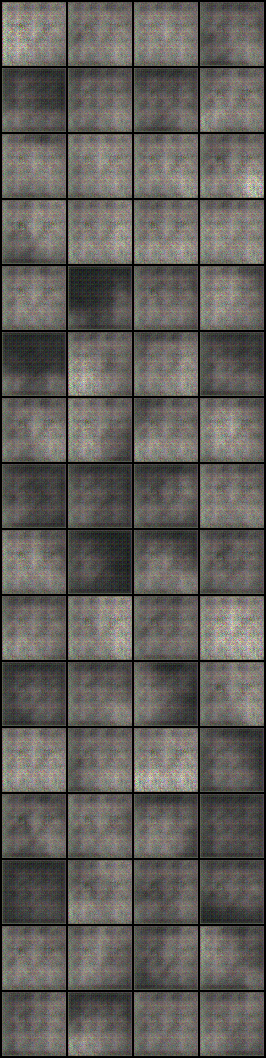

In [21]:
Image('./generated_images/img_0.png')

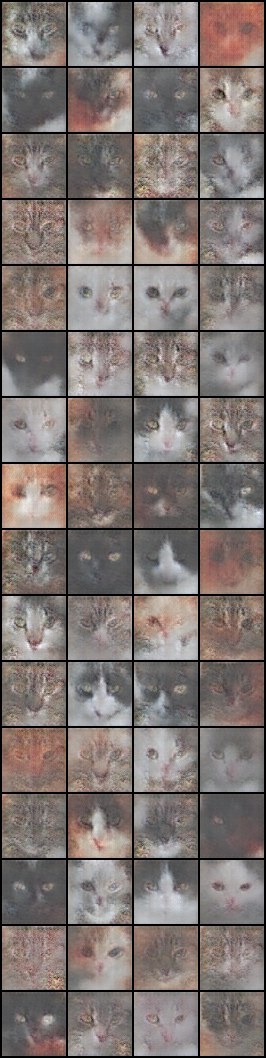

In [22]:
Image('./generated_images/img_9.png')

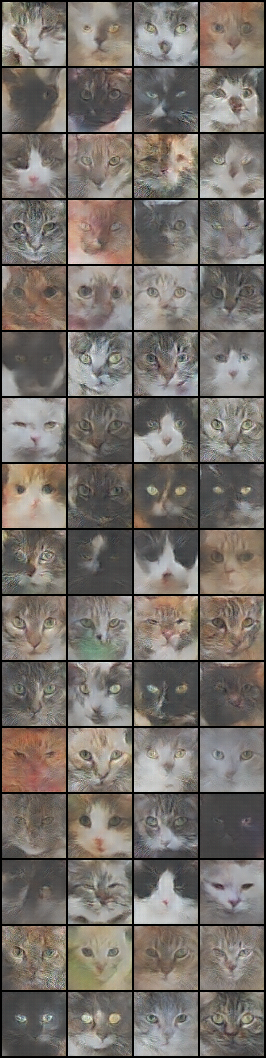

In [25]:
Image('./generated_images/img_29.png')

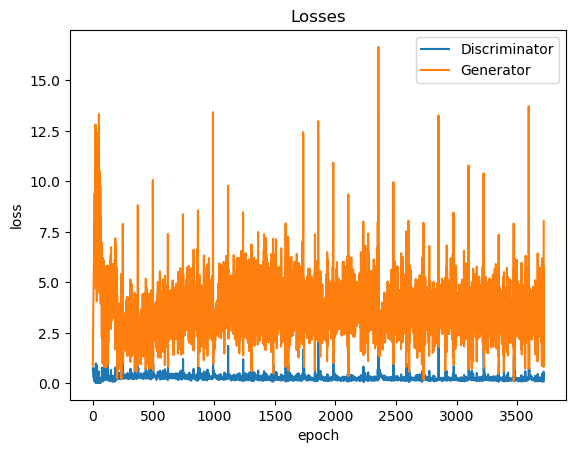

In [24]:
plt.plot([loss.cpu().item() for loss in losses_d], '-')
plt.plot([loss.cpu().item() for loss in losses_g], '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');